HEADER

In [156]:
import pandas as pd
import os

data_folder = r"C:\Users\vicky\Desktop\Football-analytics\Datasets\xP_master"

# Dictionary to hold each DataFrame
dfs = {}

# Load each file
for filename in os.listdir(data_folder):
    if filename.endswith(".parquet"):
        full_path = os.path.join(data_folder, filename)
        dfs[filename] = pd.read_parquet(full_path)
        print(f"Loaded {filename} with shape {dfs[filename].shape}")

# Access individual DataFrames, for example:
competitions_df = dfs['competitions.parquet']
matches_df = dfs['matches.parquet']
model_features_df = dfs['model_features_X.parquet']
passes_xp_df = dfs['passes_features_with_xp.parquet']
passes_raw_df = dfs['passes_raw.parquet']

Loaded competitions.parquet with shape (8, 12)
Loaded matches.parquet with shape (540, 22)
Loaded model_features_X.parquet with shape (495781, 213)
Loaded passes_features_with_xp.parquet with shape (495781, 349)
Loaded passes_raw.parquet with shape (496100, 122)


In [157]:
passes_xp_df.head()

,50_50,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_right_foot,counterpress,dribble_nutmeg,dribble_outcome,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_type,foul_won_advantage,foul_won_defensive,goalkeeper_body_part,goalkeeper_end_location,goalkeeper_outcome,goalkeeper_position,goalkeeper_punched_out,goalkeeper_technique,goalkeeper_type,id,index,interception_outcome,location,match_id,minute,off_camera,out,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,pass_end_location,pass_goal_assist,pass_height,pass_inswinging,pass_length,pass_miscommunication,pass_no_touch,pass_outcome,pass_outswinging,pass_recipient,pass_recipient_id,pass_shot_assist,pass_straight,pass_switch,pass_technique,pass_through_ball,pass_type,period,play_pattern,player,player_id,position,possession,possession_team,possession_team_id,related_events,second,shot_aerial_won,shot_body_part,shot_end_location,shot_first_time,shot_freeze_frame,shot_key_pass_id,shot_one_on_one,shot_open_goal,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure,dribble_overrun,injury_stoppage_in_chain,clearance_other,goalkeeper_shot_saved_off_target,shot_deflected,shot_saved_off_target,foul_committed_offensive,foul_committed_penalty,foul_won_penalty,miscontrol_aerial_won,shot_redirect,ball_recovery_offensive,block_save_block,goalkeeper_success_in_play,bad_behaviour_card,dribble_no_touch,shot_follows_dribble,goalkeeper_saved_to_post,half_start_late_video_start,goalkeeper_shot_saved_to_post,shot_saved_to_post,goalkeeper_lost_out,goalkeeper_lost_in_play,half_end_early_video_end,pass_backheel,player_off_permanent,goalkeeper_success_out,goalkeeper_penalty_saved_to_post,shot_kick_off,start_x,start_y,end_x,end_y,start_x_zone,start_y_zone,end_x_zone,end_y_zone,start_square,end_square,sq_start_0_0,sq_start_0_1,sq_start_0_2,sq_start_0_3,sq_start_0_4,sq_start_0_5,sq_start_0_6,sq_start_0_7,sq_start_1_0,sq_start_1_1,sq_start_1_2,sq_start_1_3,sq_start_1_4,sq_start_1_5,sq_start_1_6,sq_start_1_7,sq_start_2_0,sq_start_2_1,sq_start_2_2,sq_start_2_3,sq_start_2_4,sq_start_2_5,sq_start_2_6,sq_start_2_7,sq_start_3_0,sq_start_3_1,sq_start_3_2,sq_start_3_3,sq_start_3_4,sq_start_3_5,sq_start_3_6,sq_start_3_7,sq_start_4_0,sq_start_4_1,sq_start_4_2,sq_start_4_3,sq_start_4_4,sq_start_4_5,sq_start_4_6,sq_start_4_7,sq_start_5_0,sq_start_5_1,sq_start_5_2,sq_start_5_3,sq_start_5_4,sq_start_5_5,sq_start_5_6,sq_start_5_7,sq_start_6_0,sq_start_6_1,sq_start_6_2,sq_start_6_3,sq_start_6_4,sq_start_6_5,sq_start_6_6,sq_start_6_7,sq_start_7_0,sq_start_7_1,sq_start_7_2,sq_start_7_3,sq_start_7_4,sq_start_7_5,sq_start_7_6,sq_start_7_7,sq_start_8_0,sq_start_8_1,sq_start_8_2,sq_start_8_3,sq_start_8_4,sq_start_8_5,sq_start_8_6,sq_start_8_7,sq_start_9_0,sq_start_9_1,sq_start_9_2,sq_start_9_3,sq_start_9_4,sq_start_9_5,sq_start_9_6,sq_start_9_7,sq_start_10_0,sq_start_10_1,sq_start_10_2,sq_start_10_3,sq_start_10_4,sq_start_10_5,sq_start_10_6,sq_start_10_7,sq_start_11_0,sq_start_11_1,sq_start_11_2,sq_start_11_3,sq_start_11_4,sq_start_11_5,sq_start_11_6,sq_start_11_7,sq_end_0_0,sq_end_0_1,sq_end_0_2,sq_end_0_3,sq_end_0_4,sq_end_0_5,sq_end_0_6,sq_end_0_7,sq_end_1_0,sq_end_1_1,sq_end_1_2,sq_end_1_3,sq_end_1_4,sq_end_1_5,sq_end_1_6,sq_end_1_7,sq_end_2_0,sq_end_2_1,sq_end_2_2,sq_end_2_3,sq_end_2_4,sq_end_2_5,sq_end_2_6,sq_end_2_7,sq_end_3_0,sq_end_3_1,sq_end_3_2,sq_end_3_3,sq_end_3_4,sq_end_3_5,sq_end_3_6,sq_end_3_7,sq_end_4_0,sq_end_4_1,sq_end_4_2,sq_end_4_3,sq_end_4_4,sq_end_4_5,sq_end_4_6,sq_end_4_7,sq_end_5_0,sq_end_5_1,sq_end_5_2,sq_end_5_3,sq_end_5_4,sq_end_5_5,sq_end_5_6,sq_end_5_7,sq_end_6_0,sq_end_6_1,sq_end_6_2,sq_end_6_3,sq_end_6_4,sq_end_6_

In [158]:
len(passes_xp_df)

495781

In [159]:
matches_df.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3775648,2021-02-28,15:00:00.000,England - FA Women's Super League,2020/2021,Aston Villa,Arsenal WFC,0,4,available,scheduled,2022-11-29T22:20:07.837668,2021-06-13T16:17:31.694,11,Regular Season,Poundland Bescot Stadium,Lisa Benn,Marcus Bignot,Joseph Montemurro,1.1.0,2,2
1,3775609,2021-04-28,20:30:00.000,England - FA Women's Super League,2020/2021,Arsenal WFC,West Ham United LFC,2,0,available,scheduled,2023-02-24T20:39:46.594213,2021-06-13T16:17:31.694,13,Regular Season,Meadow Park,Emily Heaslip,Joseph Montemurro,Olli Harder,1.1.0,2,2
2,3775633,2021-02-06,13:30:00.000,England - FA Women's Super League,2020/2021,Aston Villa,Tottenham Hotspur Women,1,0,available,scheduled,2022-11-29T22:16:43.212186,2021-06-13T16:17:31.694,14,Regular Season,Poundland Bescot Stadium,Jane Simms,Marcus Bignot,Rehanne Skinner,1.1.0,2,2
3,3775570,2021-03-28,13:30:00.000,England - FA Women's Super League,2020/2021,Brighton & Hove Albion WFC,Everton LFC,0,5,available,scheduled,2021-04-13T21:46:33.264800,2021-06-13T16:17:31.694,18,Regular Season,Broadfield Stadium,Christina Hattersley,Hope Patricia Powell,Willie Kirk,1.1.0,2,2
4,3775581,2021-03-28,15:30:00.000,England - FA Women's Super League,2020/2021,Chelsea FCW,Aston Villa,2,0,available,scheduled,2023-02-24T20:38:29.557046,2021-06-13T16:17:31.694,18,Regular Season,Kingsmeadow,Sarah Garratt,Emma Hayes,Marcus Bignot,1.1.0,2,2


In [160]:
# Download lineups for all matches from StatsBomb API
# and build a dataset with player position per match + tournament

from statsbombpy.api_client import NoAuthWarning
import warnings
warnings.filterwarnings("ignore", category=NoAuthWarning)

from statsbombpy import sb
import pandas as pd

all_lineups = []

match_ids = matches_df['match_id'].dropna().unique()
total_matches = len(match_ids)

for i, match_id in enumerate(match_ids, start=1):
    
    try:
        lineups = sb.lineups(match_id=match_id)

        # statsbombpy returns one dataframe per team → stack them
        for team, df in lineups.items():
            df = df.copy()
            df['team_name'] = team
            df['match_id'] = match_id
            all_lineups.append(df)

        print(f"Downloaded {i}/{total_matches} matches", end="\r")

    except Exception as e:
        print(f"\nCould not load lineup for match {match_id}: {e}")

print("\nDownload complete")


# Combine all matches
lineups_df = pd.concat(all_lineups, ignore_index=True)


# Extract position from the nested "positions" list
def extract_primary_position(pos_list):
    if isinstance(pos_list, list) and len(pos_list) > 0:
        return pos_list[0].get('position')
    return None

lineups_df['position'] = lineups_df['positions'].apply(extract_primary_position)


# Clean columns
lineups_df = lineups_df.rename(columns={'player_name': 'player'})

lineups_df = lineups_df[
    ['match_id', 'player', 'player_id', 'team_name', 'position']
]


# Add tournament / competition from matches_df
match_to_competition = matches_df.set_index('match_id')['competition'].to_dict()
lineups_df['competition_name'] = lineups_df['match_id'].map(match_to_competition)


# Optional column order
lineups_df = lineups_df[
    ['match_id', 'competition_name', 'player', 'player_id', 'team_name', 'position']
]


print(f"Finished. Successfully processed {total_matches} matches.")
lineups_df.head()

KeyboardInterrupt: 

In [147]:
# list all unique positions
all_positions = sorted(lineups_df['position'].dropna().unique())

print("All positions in dataset:")
for p in all_positions:
    print(p)

All positions in dataset:
Center Attacking Midfield
Center Back
Center Defensive Midfield
Center Forward
Center Midfield
Goalkeeper
Left Attacking Midfield
Left Back
Left Center Back
Left Center Forward
Left Center Midfield
Left Defensive Midfield
Left Midfield
Left Wing
Left Wing Back
Right Attacking Midfield
Right Back
Right Center Back
Right Center Forward
Right Center Midfield
Right Defensive Midfield
Right Midfield
Right Wing
Right Wing Back
Secondary Striker


In [148]:
# Map detailed StatsBomb positions into 4 main categories
position_map = {
    # goalkeeper
    "Goalkeeper": "Goalkeeper",

    # defenders (including wing backs)
    "Center Back": "Defender",
    "Left Back": "Defender",
    "Right Back": "Defender",
    "Left Center Back": "Defender",
    "Right Center Back": "Defender",
    "Left Wing Back": "Defender",
    "Right Wing Back": "Defender",

    # midfield (defensive / central / attacking / wide)
    "Center Midfield": "Midfielder",
    "Left Center Midfield": "Midfielder",
    "Right Center Midfield": "Midfielder",
    "Left Midfield": "Midfielder",
    "Right Midfield": "Midfielder",
    "Center Defensive Midfield": "Midfielder",
    "Left Defensive Midfield": "Midfielder",
    "Right Defensive Midfield": "Midfielder",
    "Center Attacking Midfield": "Midfielder",
    "Left Attacking Midfield": "Midfielder",
    "Right Attacking Midfield": "Midfielder",

    # forwards
    "Center Forward": "Forward",
    "Left Center Forward": "Forward",
    "Right Center Forward": "Forward",
    "Left Wing": "Forward",
    "Right Wing": "Forward",
    "Secondary Striker": "Forward",
}

# Apply mapping
lineups_df['position_group'] = lineups_df['position'].map(position_map)

# Optional: check for positions that didn't map
unmapped = lineups_df[lineups_df['position_group'].isna()]['position'].unique()
print("Unmapped positions:", unmapped)

Unmapped positions: [None]


In [150]:
# --------------------------------------------------
# 1. Count number of main position categories per player per tournament
# --------------------------------------------------

main_pos_counts = (
    lineups_df
    .groupby(['player', 'competition_name'])['position_group']
    .nunique()
    .reset_index(name='num_main_categories')
)

distribution_main = main_pos_counts['num_main_categories'].value_counts().sort_index()

print("Player–tournament cases by number of MAIN position categories:")
print(distribution_main)

print("\nPlayed in exactly 2 main categories:",
      (main_pos_counts['num_main_categories'] == 2).sum())

print("Played in 3 or more main categories:",
      (main_pos_counts['num_main_categories'] >= 3).sum())


# --------------------------------------------------
# 2. Most common + second most common MAIN category
# --------------------------------------------------

def get_top_main_positions(group):
    counts = group['position_group'].value_counts()
    
    primary = counts.index[0] if len(counts) >= 1 else None
    secondary = counts.index[1] if len(counts) >= 2 else None
    
    return pd.Series({
        'primary_main_position': primary,
        'secondary_main_position': secondary
    })


player_tournament_main_positions = (
    lineups_df
    .groupby(['player', 'competition_name'])
    .apply(get_top_main_positions)
    .reset_index()
)


# --------------------------------------------------
# 3. Which players played multiple main categories in same tournament?
# --------------------------------------------------

multi_main = main_pos_counts[main_pos_counts['num_main_categories'] > 1]

print("\nPlayers who played more than one main category in a tournament:")
print(multi_main.head())

print("\nTotal player–tournament cases with multiple main categories:",
      len(multi_main))

Player–tournament cases by number of MAIN position categories:
num_main_categories
0     371
1    1214
2     566
3     164
Name: count, dtype: int64

Played in exactly 2 main categories: 566
Played in 3 or more main categories: 164

Players who played more than one main category in a tournament:
                 player                   competition_name  \
1  Abbey-Leigh Stringer  England - FA Women's Super League   
2            Abbi Grant  England - FA Women's Super League   
4          Abbie Larkin  International - Women's World Cup   
5           Abbie Magee         Europe - UEFA Women's Euro   
6         Abbie McManus  England - FA Women's Super League   

   num_main_categories  
1                    3  
2                    2  
4                    2  
5                    2  
6                    2  

Total player–tournament cases with multiple main categories: 730


C:\Users\vicky\AppData\Local\Temp\ipykernel_7504\1205206569.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(get_top_main_positions)


In [152]:
player_tournament_main_positions.head()

,player,competition_name,primary_main_position,secondary_main_position
0,Abbey Jones,England - FA Women's Super League,None,None
1,Abbey-Leigh Stringer,England - FA Women's Super League,Midfielder,Defender
2,Abbi Grant,England - FA Women's Super League,Forward,Midfielder
3,Abbie Cowie,England - FA Women's Super League,None,None
4,Abbie Larkin,International - Women's World Cup,Forward,Midfielder


In [161]:
# === 1️⃣ Create a DataFrame of player stats ===
player_stats = passes_xp_df.groupby('player').agg(
    avg_xP=('xP', 'mean'),            # average xP per pass
    total_xP=('xP', 'sum'),           # total xP
    total_completed=('completed', 'sum'),  # total passes actually completed
    total_xP_difference=('xP_difference', 'sum'),  # sum of xP - completed
    num_passes=('xP', 'count')        # number of passes
).sort_values('avg_xP', ascending=False)

# === 2️⃣ Add the list of matches each player played in ===
player_matches = passes_xp_df.groupby('player')['match_id'].unique()

# === 3️⃣ Combine stats and matches ===
player_profile = player_stats.join(player_matches.rename('match_id'))

# === 4️⃣ Optional: filter for players with at least 3 matches and 30 passes ===
min_matches = 3
min_passes = 30

player_profile_filtered = player_profile[
    (player_profile['match_id'].apply(len) >= min_matches) &
    (player_profile['num_passes'] >= min_passes)
]

# Add avg_xP_difference column
player_profile_filtered['avg_xP_difference'] = player_profile_filtered['total_xP_difference'] / player_profile_filtered['num_passes']

KeyError: "Column(s) ['xP_difference'] do not exist"

In [ ]:
# Create a mapping from match_id to competition
match_to_competition = matches_df.set_index('match_id')['competition'].to_dict()

# Add a new column with the competition names for each pass
passes_xp_df['competition_name'] = passes_xp_df['match_id'].map(match_to_competition)

# Now group by player and collect unique competitions they played in
player_competitions = passes_xp_df.groupby('player')['competition_name'].unique()

# Merge this with the player_profile_filtered
player_profile_filtered = player_profile_filtered.join(
    player_competitions.rename('competitions')
)

# Reset index and avoid column name conflict
player_profile_clean = player_profile_filtered.reset_index(drop=False)

# If 'competitions' also exists and conflicts, you can rename it first:
# player_profile_filtered = player_profile_filtered.rename(columns={'competitions': 'competitions_list'})

player_profile_clean.head(10)


In [ ]:
# Check number of competitions per player
player_profile_clean['num_competitions'] = player_profile_clean['competitions'].apply(lambda x: len(x))

# Filter players with more than 1 competition
players_multiple_competitions = player_profile_clean[player_profile_clean['num_competitions'] > 1]

# Display
players_multiple_competitions[['player', 'competitions', 'num_competitions']]

In [ ]:
# 1️⃣ Map match_id → competition name
match_to_competition = matches_df.set_index('match_id')['competition'].to_dict()
passes_xp_df['competition_name'] = passes_xp_df['match_id'].map(match_to_competition)


# 2️⃣ Aggregate stats per player per competition
player_comp_stats = passes_xp_df.groupby(
    ['player', 'competition_name'],
    as_index=False
).agg(
    total_xP=('xP', 'sum'),
    total_completed=('completed', 'sum'),
    num_passes=('xP', 'count')   # count rows = number of passes
)


# 3️⃣ Derived metrics
player_comp_stats['avg_xP'] = (
    player_comp_stats['total_xP'] / player_comp_stats['num_passes']
)

player_comp_stats['total_xP_difference'] = (
    player_comp_stats['total_xP'] - player_comp_stats['total_completed']
)

player_comp_stats['avg_xP_difference'] = (
    player_comp_stats['total_xP_difference'] / player_comp_stats['num_passes']
)


# 4️⃣ Prepare player profile (SAFE — no duplicate columns)

# If player is index → reset
if player_profile_filtered.index.name == 'player':
    player_profile_filtered = player_profile_filtered.reset_index()

# Remove duplicated column labels if any exist
player_profile_filtered = player_profile_filtered.loc[:, ~player_profile_filtered.columns.duplicated()]

# Profile columns you want (EDIT if needed)
profile_cols_to_keep = ['team', 'position']

# Keep only those that actually exist
existing_profile_cols = [
    c for c in profile_cols_to_keep
    if c in player_profile_filtered.columns
]

# Build base profile table (player only once)
player_profile_base = player_profile_filtered[['player'] + existing_profile_cols]



# 5️⃣ Merge stats with player profile
player_profile_long = player_comp_stats.merge(
    player_profile_base,
    on='player',
    how='left'
)


# 6️⃣ Reorder columns
cols_order = (
    ['player']
    + existing_profile_cols
    + [
        'competition_name',
        'avg_xP',
        'total_xP',
        'total_completed',
        'total_xP_difference',
        'num_passes',
        'avg_xP_difference'
    ]
)

player_profile_long = player_profile_long[cols_order]


# 7️⃣ Sort → each player grouped, best competitions first
player_profile_long = player_profile_long.sort_values(
    by=['player', 'avg_xP_difference'],
    ascending=[True, False]
).reset_index(drop=True)


# 8️⃣ Inspect
player_profile_long.head(20)

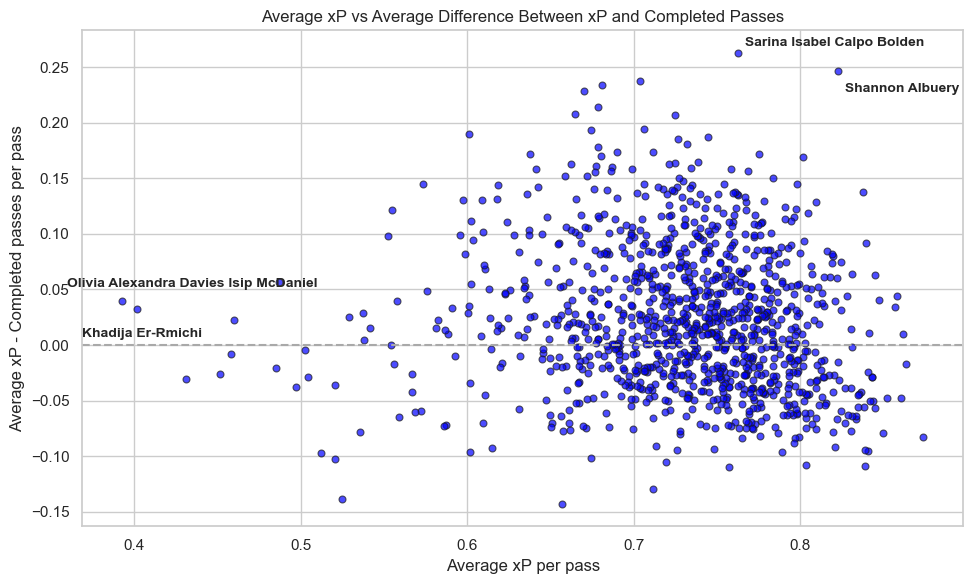

In [62]:
# All passes in all competitions

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Scatter plot with smaller points and thin border
sns.scatterplot(
    data=player_profile_filtered,
    x='avg_xP',
    y='avg_xP_difference',
    color='blue',
    s=25,               # even smaller points
    alpha=0.7,
    edgecolor='k',      # thin border
    linewidth=0.8
)

# Horizontal line for xP = Completed
plt.axhline(0, color='darkgrey', linestyle='--', label='xP = Completed Passes')

# Annotate the 2 highest points on y-axis with offsets
top_diff_players = player_profile_filtered.nlargest(2, 'avg_xP_difference')
offsets_top = [(5, 5), (5, -15)]  # fine-tuned offsets
for (i, (_, row)) in enumerate(top_diff_players.iterrows()):
    plt.annotate(
        row.name,
        xy=(row['avg_xP'], row['avg_xP_difference']),
        xytext=offsets_top[i],
        textcoords='offset points',
        fontsize=10,
        weight='bold'
    )

# Annotate the 2 leftmost points on x-axis with adjusted offsets to avoid axis
leftmost_players = player_profile_filtered.nsmallest(2, 'avg_xP')
offsets_left = [(-40, 10), (-40, -20)]  # shift right/left and up/down
for (i, (_, row)) in enumerate(leftmost_players.iterrows()):
    plt.annotate(
        row.name,
        xy=(row['avg_xP'], row['avg_xP_difference']),
        xytext=offsets_left[i],
        textcoords='offset points',
        fontsize=10,
        weight='bold'
    )

plt.title('Average xP vs Average Difference Between xP and Completed Passes')
plt.xlabel('Average xP per pass')
plt.ylabel('Average xP - Completed passes per pass')
plt.tight_layout()
plt.show()

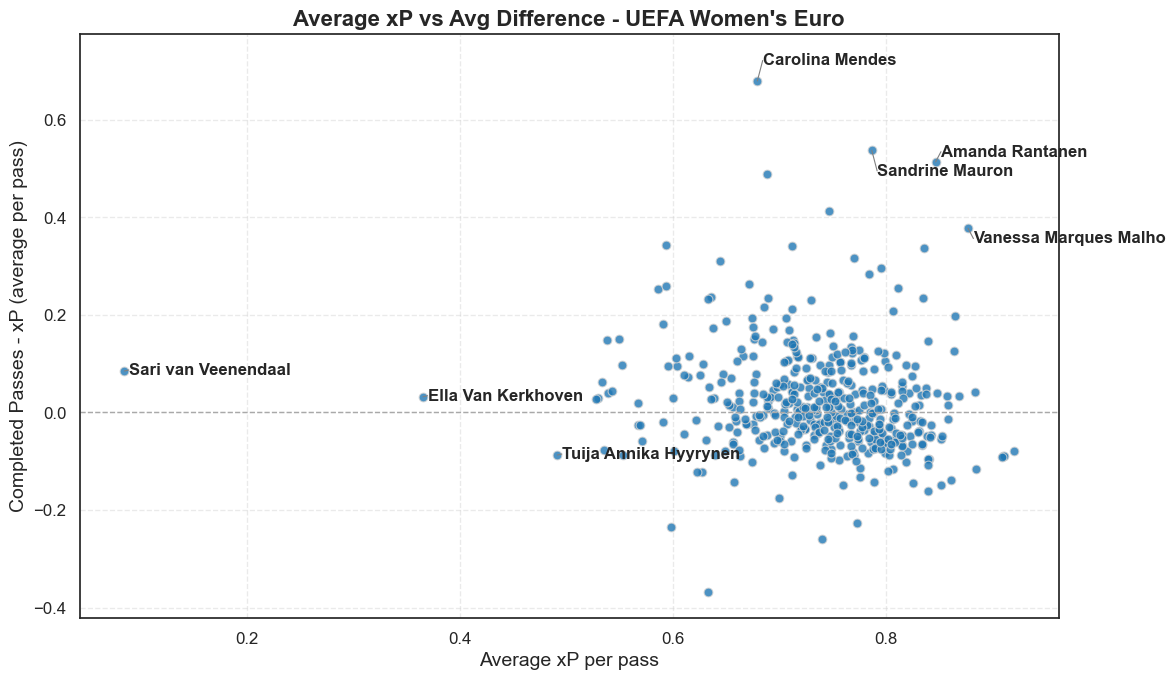

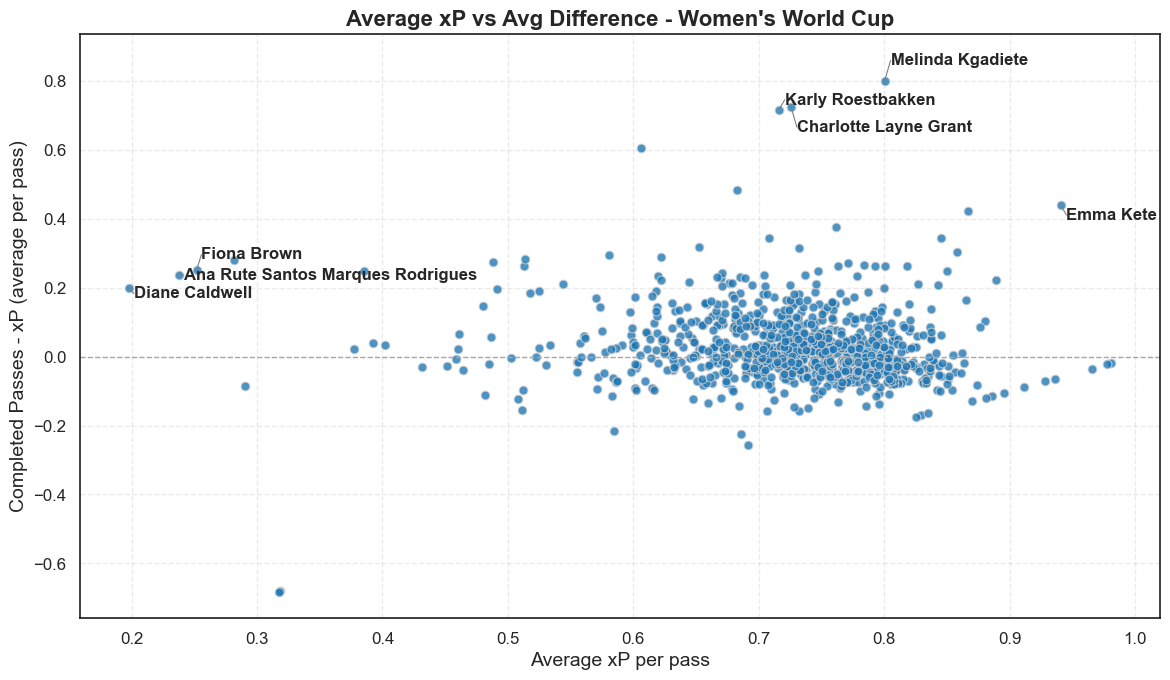

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="white", font_scale=1.1)


def plot_xP_vs_diff_labels(df, title, alternate_left=False):

    df_plot = df.reset_index(drop=True)

    plt.figure(figsize=(12, 7))

    sns.scatterplot(
        data=df_plot,
        x='avg_xP',
        y='avg_xP_difference',
        color='#1f77b4',
        s=40,
        alpha=0.8,
        edgecolor='lightgray',
        linewidth=0.8
    )

    plt.axhline(0, color='darkgray', linestyle='--', linewidth=1)

    # top-right players (clean vertical spacing)
    x_norm = (df_plot['avg_xP'] - df_plot['avg_xP'].min()) / (df_plot['avg_xP'].max() - df_plot['avg_xP'].min())
    y_norm = (df_plot['avg_xP_difference'] - df_plot['avg_xP_difference'].min()) / (df_plot['avg_xP_difference'].max() - df_plot['avg_xP_difference'].min())
    df_plot['topright_score'] = x_norm + y_norm
    topright_players = df_plot.nlargest(4, 'topright_score').sort_values('avg_xP_difference')

    y_range = df_plot['avg_xP_difference'].max() - df_plot['avg_xP_difference'].min()
    vertical_steps = [-0.02, 0.02, -0.04, 0.04]

    for i, (_, row) in enumerate(topright_players.iterrows()):
        x_offset = 0.006 * (df_plot['avg_xP'].max() - df_plot['avg_xP'].min())
        y_offset = vertical_steps[i] * y_range

        x_text = row['avg_xP'] + x_offset
        y_text = row['avg_xP_difference'] + y_offset

        plt.plot(
            [row['avg_xP'], x_text],
            [row['avg_xP_difference'], y_text],
            color='gray',
            lw=0.8
        )

        plt.text(
            x_text,
            y_text,
            row['player'],
            fontsize=12,
            weight='bold',
            va='center',
            ha='left'
        )

    # lowest avg_xP players (left side)
    left_players = df_plot.nsmallest(3, 'avg_xP')
    offsets_vertical = [-0.01, -0.001, 0.03]

    for i, (_, row) in enumerate(left_players.iterrows()):
        x_offset = 0.005 * (df_plot['avg_xP'].max() - df_plot['avg_xP'].min())

        if alternate_left:
            y_offset = offsets_vertical[i] * y_range
        else:
            y_offset = 0.002 * y_range

        x_text = row['avg_xP'] + x_offset
        y_text = row['avg_xP_difference'] + y_offset

        plt.plot(
            [row['avg_xP'], x_text],
            [row['avg_xP_difference'], y_text],
            color='gray',
            lw=0.8
        )

        plt.text(
            x_text,
            y_text,
            row['player'],
            fontsize=12,
            weight='bold',
            va='center',
            ha='left'
        )

    plt.title(title, fontsize=16, weight='bold')
    plt.xlabel('Average xP per pass', fontsize=14)
    plt.ylabel('Completed Passes - xP (average per pass)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


MIN_PASSES = 0


euros_df = player_profile_long[
    (player_profile_long['competition_name'] == "Europe - UEFA Women's Euro") &
    (player_profile_long['num_passes'] >= MIN_PASSES)
]

plot_xP_vs_diff_labels(
    euros_df,
    "Average xP vs Avg Difference - UEFA Women's Euro",
    alternate_left=False
)


wc_df = player_profile_long[
    (player_profile_long['competition_name'] == "International - Women's World Cup") &
    (player_profile_long['num_passes'] >= MIN_PASSES)
]

plot_xP_vs_diff_labels(
    wc_df,
    "Average xP vs Avg Difference - Women's World Cup",
    alternate_left=True
)